In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import accelerate

accelerator = accelerate.Accelerator(
    log_with="tensorboard", 
    project_dir=".xvla",
    fsdp_plugin=accelerate.FullyShardedDataParallelPlugin(),
)

In [3]:
from xvla_wlr.model import XVLA, XVLAProcessor, Trainer, get_peft_model, Action, Observation

model = XVLA.from_pretrained("2toINF/X-VLA-SoftFold")
processor = XVLAProcessor.from_pretrained("2toINF/X-VLA-SoftFold", use_fast=True)

Florence2ForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
model = get_peft_model(model)
model, processor = accelerator.prepare(model, processor)
trainer = Trainer(model, processor, accelerator=accelerator)

In [5]:
import os

from datasets_wlr import WLRZhuangEpisodeDataset
from curobo.types.robot import RobotConfig
from xvla_wlr.model import DATA_DOMAIN_ID


dataset = WLRZhuangEpisodeDataset("samples/2026-01-21_demo_clothes/episode_0/data.json")
# TODO rm
# robot_config = RobotConfig.from_basic(
#     f"{os.getcwd()}/robots/piper_ros/src/piper_description/urdf/piper_description.urdf",
#     base_link="base_link",
#     ee_link="link8",
# )
domain_id = DATA_DOMAIN_ID["robomind-agilex"]


from xvla_wlr_experiments.xvla_finetune_piper_v0.dataset import XVLAWLRZhuangEpisodeDataset

# TODO
xvla_dataset = XVLAWLRZhuangEpisodeDataset(
    dataset=dataset,
    robot_config_left=RobotConfig.from_basic(
        f"{os.getcwd()}/robots/piper-dualarm/piper-dualarm.urdf",
        base_link="common_base_link",
        ee_link="left_link8",
    ),
    robot_config_right=RobotConfig.from_basic(
        f"{os.getcwd()}/robots/piper-dualarm/piper-dualarm.urdf",
        base_link="common_base_link",
        ee_link="right_link8",
    ),
    domain_id=domain_id,
    prefetch=True,
)

kinematics_fused_cu not found, JIT compiling...
geom_cu binary not found, jit compiling...
lbfgs_step_cu not found, JIT compiling...
line_search_cu not found, JIT compiling...
tensor_step_cu not found, jit compiling...


In [6]:
import torch
torch._logging.set_logs(graph_breaks=True)

In [7]:
import torch
torch.set_float32_matmul_precision("high")
torch._dynamo.config.compiled_autograd = True
fit = torch.compile(trainer.fit, mode="max-autotune")

In [11]:
timestep_current = 0
num_timesteps_per_episode = 4
num_timesteps_per_action = 2


observation = xvla_dataset[
    timestep_current
    :timestep_current + num_timesteps_per_episode
]

action = Action.from_observation(
    observation,
    num_steps=num_timesteps_per_action,
)

action_next = action[1:]
observation_current = observation[:len(action_next)]

loss = fit(
    observation=observation_current,
    action=action_next,
)    

with torch.profiler.profile() as prof:
    loss = fit(
        observation=observation_current,
        action=action_next,
    )    
prof.export_chrome_trace("trace-train.json")


In [37]:
processor.image_processor.rescale

<bound method BaseImageProcessorFast.rescale of CLIPImageProcessorFast {
  "auto_map": {
    "AutoProcessor": "2toINF/X-VLA-SoftFold--processing_xvla.XVLAProcessor"
  },
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "do_center_crop": false,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "CLIPImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "processor_class": "XVLAProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 224,
    "width": 224
  }
}
>

In [18]:
torch.set_default_device("cuda")

In [22]:
observation.images.device

device(type='cpu')

In [23]:
processor.process_image?

Signature: processor.process_image(images: Ellipsis, **kwargs)
Docstring: <no docstring>
File:      ~/X-VLA/packages/xvla_wlr/xvla/models/processing_xvla.py
Type:      method

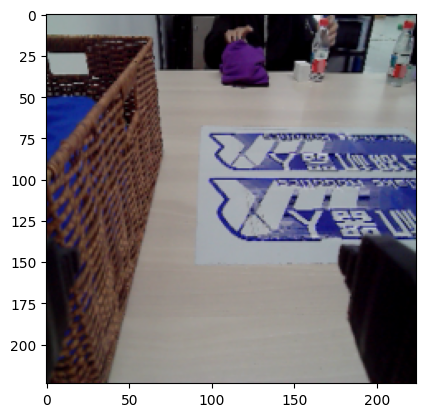

In [38]:
import einops
image = processor.process_image(observation.images, do_normalize=False, do_rescale=False)
im = einops.rearrange(image, "b cam c h w -> b cam h w c")[1][0]
import matplotlib.pyplot as plt
plt.imshow(im.numpy(force=True))

In [13]:
timestep_current = 0
num_timesteps_per_episode = 4
num_timesteps_per_action = 2


while True:
    if timestep_current + num_timesteps_per_episode >= len(xvla_dataset):
        break
    observation = xvla_dataset[
        timestep_current
        :timestep_current + num_timesteps_per_episode
    ]

    action = Action.from_observation(
        observation,
        num_steps=num_timesteps_per_action,
    )

    action_next = action[1:]
    observation_current = observation[:len(action_next)]

    loss = fit(
        observation=observation_current,
        action=action_next,
    )

    timestep_current += len(observation_current)

    if timestep_current % 100 == 0:
        print("TODO episode", timestep_current, loss)


TODO episode 100 tensor(59.2072, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 200 tensor(65.2520, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 300 tensor(21.4023, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 400 tensor(14.1627, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 500 tensor(9.0355, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 600 tensor(21.0783, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 700 tensor(9.5062, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 800 tensor(11.8395, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 900 tensor(48.9121, device='cuda:0', grad_fn=<CompiledFunctionBackward>)
TODO episode 1000 tensor(119.9614, device='cuda:0', grad_fn=<CompiledFunctionBackward>)


In [13]:
model.save_pretrained("todo-checkpoint")
processor.save_pretrained("todo-processor-checkpoint")

[]

In [15]:
from xvla_wlr.model import compute_actions

compute_actions(model, processor, observation=Observation.sample())

Action(ee_transforms=tensor([[[[[-4.6944e-01,  8.3727e-01,  2.8037e-01, -3.3286e-01],
           [ 7.2192e-01,  5.4679e-01, -4.2410e-01, -2.4773e-01],
           [-5.0838e-01,  3.3159e-03, -8.6112e-01, -2.5378e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

          [[-6.6064e-01, -6.6388e-01,  3.5046e-01,  3.0574e-01],
           [-5.5109e-01,  1.1188e-01, -8.2691e-01,  4.2923e-01],
           [ 5.0976e-01, -7.3942e-01, -4.3977e-01, -4.0793e-01],
           [ 0.0000e+00,  0.0000e+00,  4.6243e-44,  1.0000e+00]]],


         [[[-4.7804e-01,  8.3728e-01,  2.6540e-01, -3.3335e-01],
           [ 7.2133e-01,  5.4664e-01, -4.2529e-01, -2.4628e-01],
           [-5.0116e-01, -1.1861e-02, -8.6527e-01, -2.5613e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

          [[-6.5206e-01, -6.6615e-01,  3.6203e-01,  3.0015e-01],
           [-5.5798e-01,  9.8352e-02, -8.2401e-01,  4.4095e-01],
           [ 5.1331e-01, -7.3930e-01, -4.3583e-01, -4.0938e-0

In [8]:
import torch, torch._dynamo as dynamo

report = dynamo.explain(fit)(
    observation=observation_current,
    action=action_next,
)

/home/ace/X-VLA/.conda/lib/python3.11/site-packages/torch/_dynamo/variables/functions.py:1692: UserWarning: Dynamo detected a call to a `functools.lru_cache`-wrapped function. Dynamo ignores the cache wrapper and directly traces the wrapped function. Silent incorrectness is only a *potential* risk, not something we have observed. Enable TORCH_LOGS="+dynamo" for a DEBUG stack trace.
  torch._dynamo.utils.warn_once(msg)


In [9]:
for i, r in enumerate(report.break_reasons):
    print(f"[{i}] {r.reason}")
    for fr in r.user_stack:
        print("   ", fr)

[0] Attempted to call function marked as skipped
  Explanation: Dynamo developers have intentionally marked that the function `find_spec` in file `<frozen importlib.util>` should not be traced.
  Hint: Avoid calling the function `find_spec`.
  Hint: Apply `@torch._dynamo.dont_skip_tracing` to the function `find_spec` to force tracing into the function. More graph breaks may occur as a result of attempting to trace into the function.
  Hint: Please file an issue to PyTorch.

  Developer debug context: module: importlib.util, qualname: find_spec, skip reason: <missing reason>

 For more details about this graph break, please visit: https://meta-pytorch.github.io/compile-graph-break-site/gb/gb0007.html
    <FrameSummary file /home/ace/X-VLA/packages/xvla_wlr/xvla/models/processing_xvla.py, line 118 in process_image>
    <FrameSummary file /home/ace/X-VLA/.conda/lib/python3.11/site-packages/transformers/image_processing_utils.py, line 42 in __call__>
    <FrameSummary file /home/ace/X-VLA/